In [34]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import  precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import unidecode

In [35]:
df = pd.read_csv('clarin_articles.csv')
stopwords = pd.read_csv('stopwords.csv', header= None)

In [36]:
df.head()

,articleBody,bajada,headline,section,volanta
0,"Lucas Rodríguez, integrante de la Selección Na...",Lucas Rodríguez hizo un video solicitándole al...,Sancionan a un jugador de Los Murciélagos por ...,de Deportes,Fútbol para ciegos
1,Luego de la histórica conquista en Indian Well...,El número 6 del mundo se acercó a una chica qu...,El gran gesto de Del Potro con una admiradora ...,de Deportes,Tenis
2,La Cámara de Diputados debatió ayer un proyect...,"Hasta ahora sólo es contravención, en la Ciuda...",Debaten en Diputados un proyecto para penaliza...,de Sociedad,Violencia de género
3,"¡Y algún día serán como Marcelo T. de Alvear, ...",Las autoridades del Colegio creen que pueden l...,El Nacional Buenos Aires espera arrancar su in...,de Sociedad,Ansiedad entre los aspirantes
4,"En su primera sesión ordinaria del año, la Cám...","Es Romina del Plá, del Partido Obrero. Habló c...",Una diputada de izquierda fue la única que no ...,de Política,Se aprobaron penas


In [37]:
df.dtypes

articleBody    object
bajada         object
headline       object
section        object
volanta        object
dtype: object

In [38]:
stopwords_list = stopwords[0].values
stopwords_list = list(stopwords_list)

In [39]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [40]:
def text_stemmer(text):
    if type(text) is str:
        texto = text.lower()
        unaccented_string = unidecode.unidecode(texto)
        stripped = re.sub('[^a-z0-9]+', ' ', unaccented_string).lstrip()
        stemmed = " ".join([stemmer.stem(x) for x in stripped.split(' ')])
        return stemmed

In [41]:
df['articleBody2'] = df["articleBody"].apply(text_stemmer)

In [42]:
df.section.unique()

array(['de Deportes', 'de Sociedad', 'de Política', 'de Tecnología',
       'de Espectáculos', 'las más leídas', 'de Clarín', 'de Economía',
       'de Mundo', 'de Viva', nan, 'de viajes', 'de Mundial 2018',
       'de Autos', 'de Rural', 'de Buena Vida', 'de Cine',
       'de Entremujeres', 'de New York Times International Weekly'],
      dtype=object)

In [43]:
df_sections = df[(df.section == 'de Política') | (df.section == 'de Economía')]
df_sections = df_sections[pd.notnull(df_sections['articleBody2'])]
df_sections.head()


,articleBody,bajada,headline,section,volanta,articleBody2
4,"En su primera sesión ordinaria del año, la Cám...","Es Romina del Plá, del Partido Obrero. Habló c...",Una diputada de izquierda fue la única que no ...,de Política,Se aprobaron penas,en su primer sesion ordinari del ano la cam de...
6,"En un duro revés para el Gobierno, la Justicia...",La Justicia consideró que no se justificaba el...,Declaran inconstitucional el decreto de Macri ...,de Política,Revés para el Gobierno,en un dur rev par el gobiern la justici declar...
16,Después de la masiva respuesta que obtuvieron ...,Es luego de las manifestaciones del último dom...,Los anti abortistas suben la apuesta y no desc...,de Política,Debate público,despu de la masiv respuest que obtuv en las ma...
23,El lonko Facundo Jones Huala lleva nueve meses...,El líder mapuche lleva 9 meses detenido. Se al...,"Facundo Jones Huala en prisión: aislado, escuc...",de Política,Conflicto en la Patagonia,el lonk facund jon hual llev nuev mes en prisi...
27,El estudio científico hecho sobre las muestras...,Las pruebas dieron positivas en 2 manifestante...,Caso Rafael Nahuel: las pericias determinaron ...,de Política,Conflicto en el Sur,el estudi cientif hech sobr las muestr tom en ...


In [44]:
df_sections.groupby('section')['articleBody2'].count()

section
de Economía     54
de Política    177
Name: articleBody2, dtype: int64

In [45]:
X = df_sections['articleBody2']
y = df_sections['section']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(strip_accents= 'ascii', stop_words= stopwords_list)
count_vect.fit(X_train)
X_train_counts = count_vect.transform(X_train)

X_train_counts.shape

(154, 7328)

In [48]:
X_test_counts = count_vect.transform(X_test)

In [49]:
def get_report(test_features,test_target,model, model_name):
    y_pred = model.predict_proba(test_features)
    y_pred_abs = model.predict(test_features)
    Ytest = list(map(lambda x : 1 if(x == "Política") else 0,test_target))
    fpr_log,tpr_log,thr_log = roc_curve(Ytest, y_pred[:,1])
    df_aux = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('Curve')
    plt.plot(df_aux['fpr'],df_aux['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    print("\n Classification Report: \n")
    print(confusion_matrix(test_target, y_pred_abs))
    print("-------------------------------------------\n")

# Naive Bayes

In [50]:
model_multinb = MultinomialNB().fit(X_train_counts, y_train)
y_pred_multinb = model_multinb.predict(X_test_counts)

print('Accuracy Naive Bayes: ',accuracy_score(y_pred_multinb, y_test))

Accuracy Naive Bayes:  0.8831168831168831


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


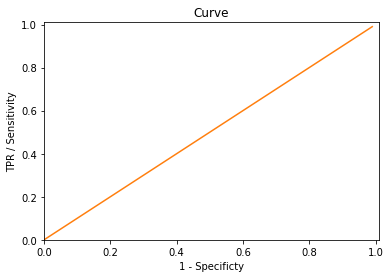


 Classification Report: 

[[11  4]
 [ 5 57]]
-------------------------------------------



In [51]:
get_report(X_test_counts,y_test,model_multinb," Naive Bayes")

In [52]:
df_results = pd.DataFrame(X_test)
df_results['Prediction'] = y_pred_multinb
df_results.head(5)

,articleBody2,Prediction
456,la legalizacion del abort tuv su histor debat ...,de Política
492,com poc vec sus par ministr esper con expect q...,de Política
427,a un ano de que fue vist con vid por ultim vez...,de Política
501,alfred caser consider que la metafor del flan ...,de Política
442,ypf volvi a aument este doming el preci de las...,de Economía


# KNN

In [53]:
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train_counts,y_train)
y_pred_knn = model_knn.predict(X_test_counts)
print('Accuracy KNN: ',accuracy_score(y_pred_knn, y_test))

Accuracy KNN:  0.8311688311688312


In [54]:
X_counts = count_vect.transform(X)
from sklearn.model_selection import cross_val_score
scores_para_df_standar = []
for i in range(1,100,5):
    model_knn = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model_knn, X_counts, y, cv=5)
    dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}
    scores_para_df_standar.append(dict_row_score)

In [55]:
df_scores_standar = pd.DataFrame(scores_para_df_standar)
#df_scores_standar
df_scores_standar.sort_values(by="score_medio",ascending=False).head(5)

,n_neighbours,score_medio,score_std
5,26,0.787752,0.029352
4,21,0.778867,0.049441
9,46,0.770634,0.008167
6,31,0.770542,0.010384
7,36,0.770542,0.010384


In [56]:
model_knn = KNeighborsClassifier(n_neighbors=16)
model_knn.fit(X_train_counts,y_train)
y_pred_knn = model_knn.predict(X_test_counts)
print('Accuracy KNN: ',accuracy_score(y_pred_knn, y_test))

Accuracy KNN:  0.8441558441558441


In [57]:
df_scores_standar['limite_superior'] = df_scores_standar['score_medio'] + df_scores_standar['score_std']
df_scores_standar['limite_inferior'] = df_scores_standar['score_medio'] - df_scores_standar['score_std']

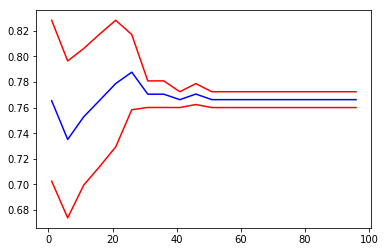

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_inferior'],color='r')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['score_medio'],color='b')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_superior'],color='r');

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


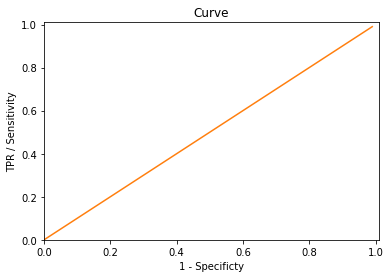


 Classification Report: 

[[ 5 10]
 [ 2 60]]
-------------------------------------------



In [59]:
get_report(X_test_counts,y_test,model_knn,"KNN (n=16)")

# Regresión Logística

In [60]:
model_log = LogisticRegression(C=0.1)
model_log.fit(X_train_counts, y_train)
y_pred_log = model_log.predict(X_test_counts)
print('Accuracy Logistic Regression: ',accuracy_score(y_pred_log, y_test))

Accuracy Logistic Regression:  0.9090909090909091


In [61]:
df_results = pd.DataFrame(X_test)
df_results['Prediction'] = y_pred_log
df_results.head(10)

,articleBody2,Prediction
456,la legalizacion del abort tuv su histor debat ...,de Política
492,com poc vec sus par ministr esper con expect q...,de Política
427,a un ano de que fue vist con vid por ultim vez...,de Política
501,alfred caser consider que la metafor del flan ...,de Política
442,ypf volvi a aument este doming el preci de las...,de Economía
641,facund jon hual denunci que en la carcel conce...,de Política
94,el part justicial pj cuy doctrin histor es log...,de Política
46,en 2017 la deud public intern y extern en pes ...,de Economía
105,las critic a la iglesi que surg con ocasion de...,de Política
446,chinin es un lug emblemat par los vecin de san...,de Política


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


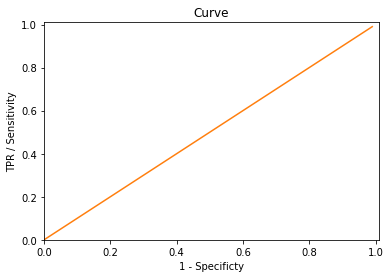


 Classification Report: 

[[11  4]
 [ 3 59]]
-------------------------------------------



In [62]:
get_report(X_test_counts,y_test,model_log,"Regresión Logística (c=0.1)")